In [15]:
file_path : str = "../testdata/test2_output/shading_corrected.zarr/"
output_dir = "../testdata/test2_output"
metadata_path = "../testdata/test2_output/test2_metadata.yaml"

output_csv_name = "stitch_positions.csv"
output_image_name = "stitched.zarr"

stitch_every_t = 0
target_channel = '10x_Fukai_DIA_IS_1'
num_cpus = 10
try_ncc_thresholds = [0.5, 0.05, 0.02, 0.01]

In [3]:
from pathlib import Path
file_path = Path(file_path)
assert file_path.exists()
output_csv_path = Path(output_dir) / output_csv_name
output_image_path = Path(output_dir) / output_image_name
metadata_path = Path(metadata_path)

# Import packages and define functions

In [4]:
import pandas as pd
import numpy as np
from itertools import combinations
import networkx as nx
from m2stitch import stitch_images
import zarr
from matplotlib import pyplot as plt
import numpy as np
import joblib
from IPython.display import display
from dask import array as da
import yaml
from utils import merge_mosaic_images

In [5]:
def _calc_overlap_area_ratio(image_shape,relative_pos):
    """Calculate the image overlap area ratio with respect to the image area.
    
    """
    percentage = 1.
    for s, p in zip(image_shape,relative_pos):
        percentage *= np.clip(1-np.abs(p/s),0,None)
    return percentage


def parse_positions_to_pairs(
    image_shape,
    tile_indices = None, 
    estimated_positions = None,
    overlap_threshold_percentage : float = 5,
    ):
    """Parse image positions to image pairs.

    Parameters
    ----------
    image_shape : List[Int]
        The shape of a single input image.
    tile_indices : Optional[IntArray], optional
        The integer index of the tiles. If None, `estimated_positions` must be supplied.
    estimated_positions : Optional[NumArray], optional
        The estimated position of the tiles in pixel. If None, `tile_indices` must be supplied.
    overlap_threshold_percentage : float, optional
        The area percentage threshold to calculate pair displacement between tiles. Effective only when tile_indices is None.
    """

    image_pairs = []
    if tile_indices is not None:
        for (j1,ind1), (j2,ind2) in combinations(enumerate(tile_indices),2):
            # if the images are the next to each other or at the same position
            diff = np.abs(ind1 - ind2)
            if ((np.max(diff) == 1 and np.sum(diff == 1) == 1)) or np.all(ind1 == ind2): 
                if estimated_positions is not None:
                    dpos = estimated_positions[j2]-estimated_positions[j1]
                else:
                    dpos = None
                image_pairs.append({
                    "image_index1":j1,
                    "image_index2":j2,
                    "index_displacement":ind2-ind1,
                    "estimated_displacement":dpos,
                }) # image 2 position with respect to image 1
    else:
        for (j1,pos1), (j2,pos2) in combinations(enumerate(estimated_positions),2):
            if _calc_overlap_area_ratio(image_shape,np.array(pos2)-np.array(pos1)) > overlap_threshold_percentage/100:
                image_pairs.append({
                    "image_index1":j1,
                    "image_index2":j2,
                    "index_displacement":None,
                    "estimated_displacement":pos2-pos1
                })
    
    if len(image_pairs) == 0:
        raise RuntimeError("There is no valid image pairs. Please check tile_indices and estimated_positions.")

    pairs_df = pd.DataFrame.from_records(image_pairs)
    pairs_graph = nx.Graph()
    nodes_count = len(estimated_positions if estimated_positions is not None else tile_indices) 
    pairs_graph.add_nodes_from(range(nodes_count))
    pairs_graph.add_edges_from(pairs_df[["image_index1","image_index2"]].values)

    if len(list(nx.connected_components(pairs_graph))) > 1:
        raise ValueError("Parsing positions resulted more than one connected graphs.")

    return pairs_df

In [6]:
images = zarr.open(str(file_path))
metadata = yaml.safe_load(metadata_path.read_text())

In [7]:
channel_names = metadata["channel_names"]
print(channel_names)
if target_channel in channel_names:
    target_channel_index = channel_names.index(target_channel)
else:
    _target_channel_index = int(target_channel.split("_")[-1])
    target_channel_prefix = "_".join(target_channel.split("_")[:-1])
    target_channel_index = [i for i, name in enumerate(channel_names) if name == target_channel_prefix][_target_channel_index]
print(target_channel_index, channel_names[target_channel_index])

['10x_Fukai_DIA_IS', '10x_Fukai_DIA_IS']
1 10x_Fukai_DIA_IS


In [8]:
mosaic_positions = metadata["mosaic_positions"]
display(mosaic_positions[:10])

mosaic_positions = np.array(mosaic_positions)
ok_inds=np.linalg.norm(mosaic_positions[1:]-mosaic_positions[:-1],axis=1) < np.max(images.shape[-2:])*1.5 # assume stage moves less than 1.5x of the image size
ok_inds = [True] + list(ok_inds)
#ok_inds = np.array(ok_inds) & (np.arange(mosaic_positions.shape[0])<max_ind)
mosaic_positions = mosaic_positions[ok_inds,:]

[[-9256.679704924027, -2723.983470101535],
 [-9396.41955773792, -200.85014553552105],
 [-9536.159410551814, 2322.283179030493],
 [-9675.899263365709, 4845.416503596507],
 [-7633.982482156359, 7489.377520445213],
 [-7494.242629342464, 4966.244195879199],
 [-7354.502776528569, 2443.110871313185],
 [-7214.762923714674, -80.02245325282935],
 [-7075.023070900778, -2603.1557778188435],
 [-4893.366436877533, -2482.3280855361522]]

In [9]:
mosaic_positions = np.array(mosaic_positions)
pairs =  parse_positions_to_pairs(
    images.shape[-2:],
    estimated_positions = mosaic_positions,
    overlap_threshold_percentage  = 2,
)

index_positions = [None for _ in range(len(mosaic_positions))]
index_positions[0] = np.array([0,0])

# Change absolute positions to index difference (removed after migrating to microtailor)
for i in range(10):
    for i, row in pairs.iterrows():
        for sign, (i1, i2) in zip([1,-1],[(row.image_index1,row.image_index2),(row.image_index2,row.image_index1)]):
            if index_positions[i1] is not None:
                disp = row.estimated_displacement
                index_displacement = (np.abs(disp) > np.min(images.shape[-2:])*0.5).astype(int) * np.sign(disp) * sign
                calc_pos = index_positions[i1] + index_displacement

                if index_positions[i2] is None:
                    index_positions[i2] = calc_pos
                else:
                    assert np.all(index_positions[i2] == calc_pos)
assert not np.any([p is None for p in index_positions])
index_positions = np.array(index_positions)
index_positions -= np.min(index_positions,axis=0)
index_positions = index_positions.astype(int)
print(index_positions[:10])

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [1 4]
 [1 3]
 [1 2]
 [1 1]
 [1 0]
 [2 0]]


In [10]:
target_Ts = [0] if stitch_every_t == 0 else list(range(0, images.shape[2], stitch_every_t))

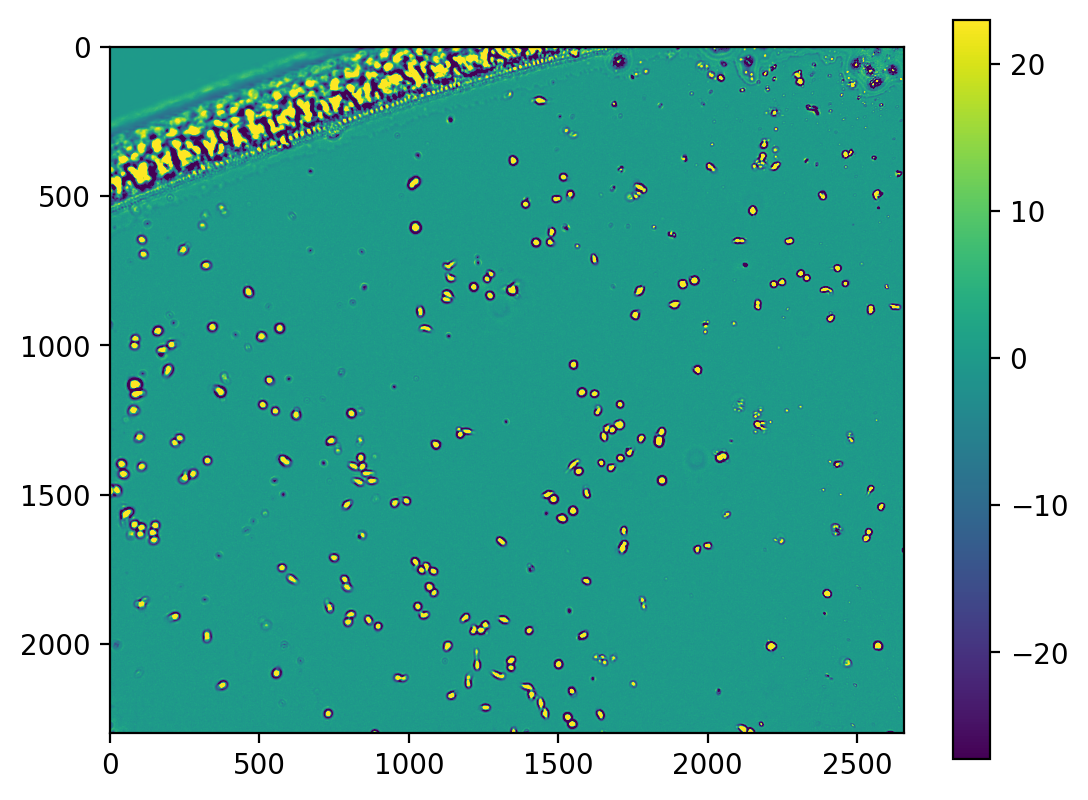

In [11]:
qs = np.percentile(
    np.concatenate([
        np.ravel(images[:,target_T,target_channel_index]) 
        for target_T in target_Ts]),q=[1,99])
plt.imshow(images[0,target_Ts[0],target_channel_index,0],vmax=qs[1],vmin=qs[0])
plt.colorbar()

In [14]:
try_ncc_thresholds 

[0.5, 0.2, 0.1]

In [16]:
def stitch_T(T):
    target_images = np.array([images[ind,T,target_channel_index] for ind in np.nonzero(ok_inds)[0]])
    assert target_images.shape[1] == 1
    target_images = target_images[:,0]
    positions = None
    for ncc_threshod in try_ncc_thresholds:
        try: 
            positions, _ = stitch_images(
                target_images,
                position_indices = index_positions,
                position_initial_guess = mosaic_positions,
                row_col_transpose=False,
                ncc_threshold=ncc_threshod,
            )
            break
        except AssertionError as e:
            if "try lowering the ncc_threshold" in str(e):
                continue
            else:
                raise e
    if positions is None:
        raise ValueError("Stitching failed.")
    positions.assign(T=T)
    return positions

In [17]:
T = target_Ts[0]
with joblib.Parallel(n_jobs=num_cpus) as parallel:
    positions = parallel(joblib.delayed(stitch_T)(_T) for _T in [T])[0]
target_images = np.array([images[ind,T,target_channel_index] for ind in np.nonzero(ok_inds)[0]])


100%|██████████| 48/48 [00:00<00:00, 128.82it/s]


In [18]:
target_images.shape

(48, 1, 2296, 2656)

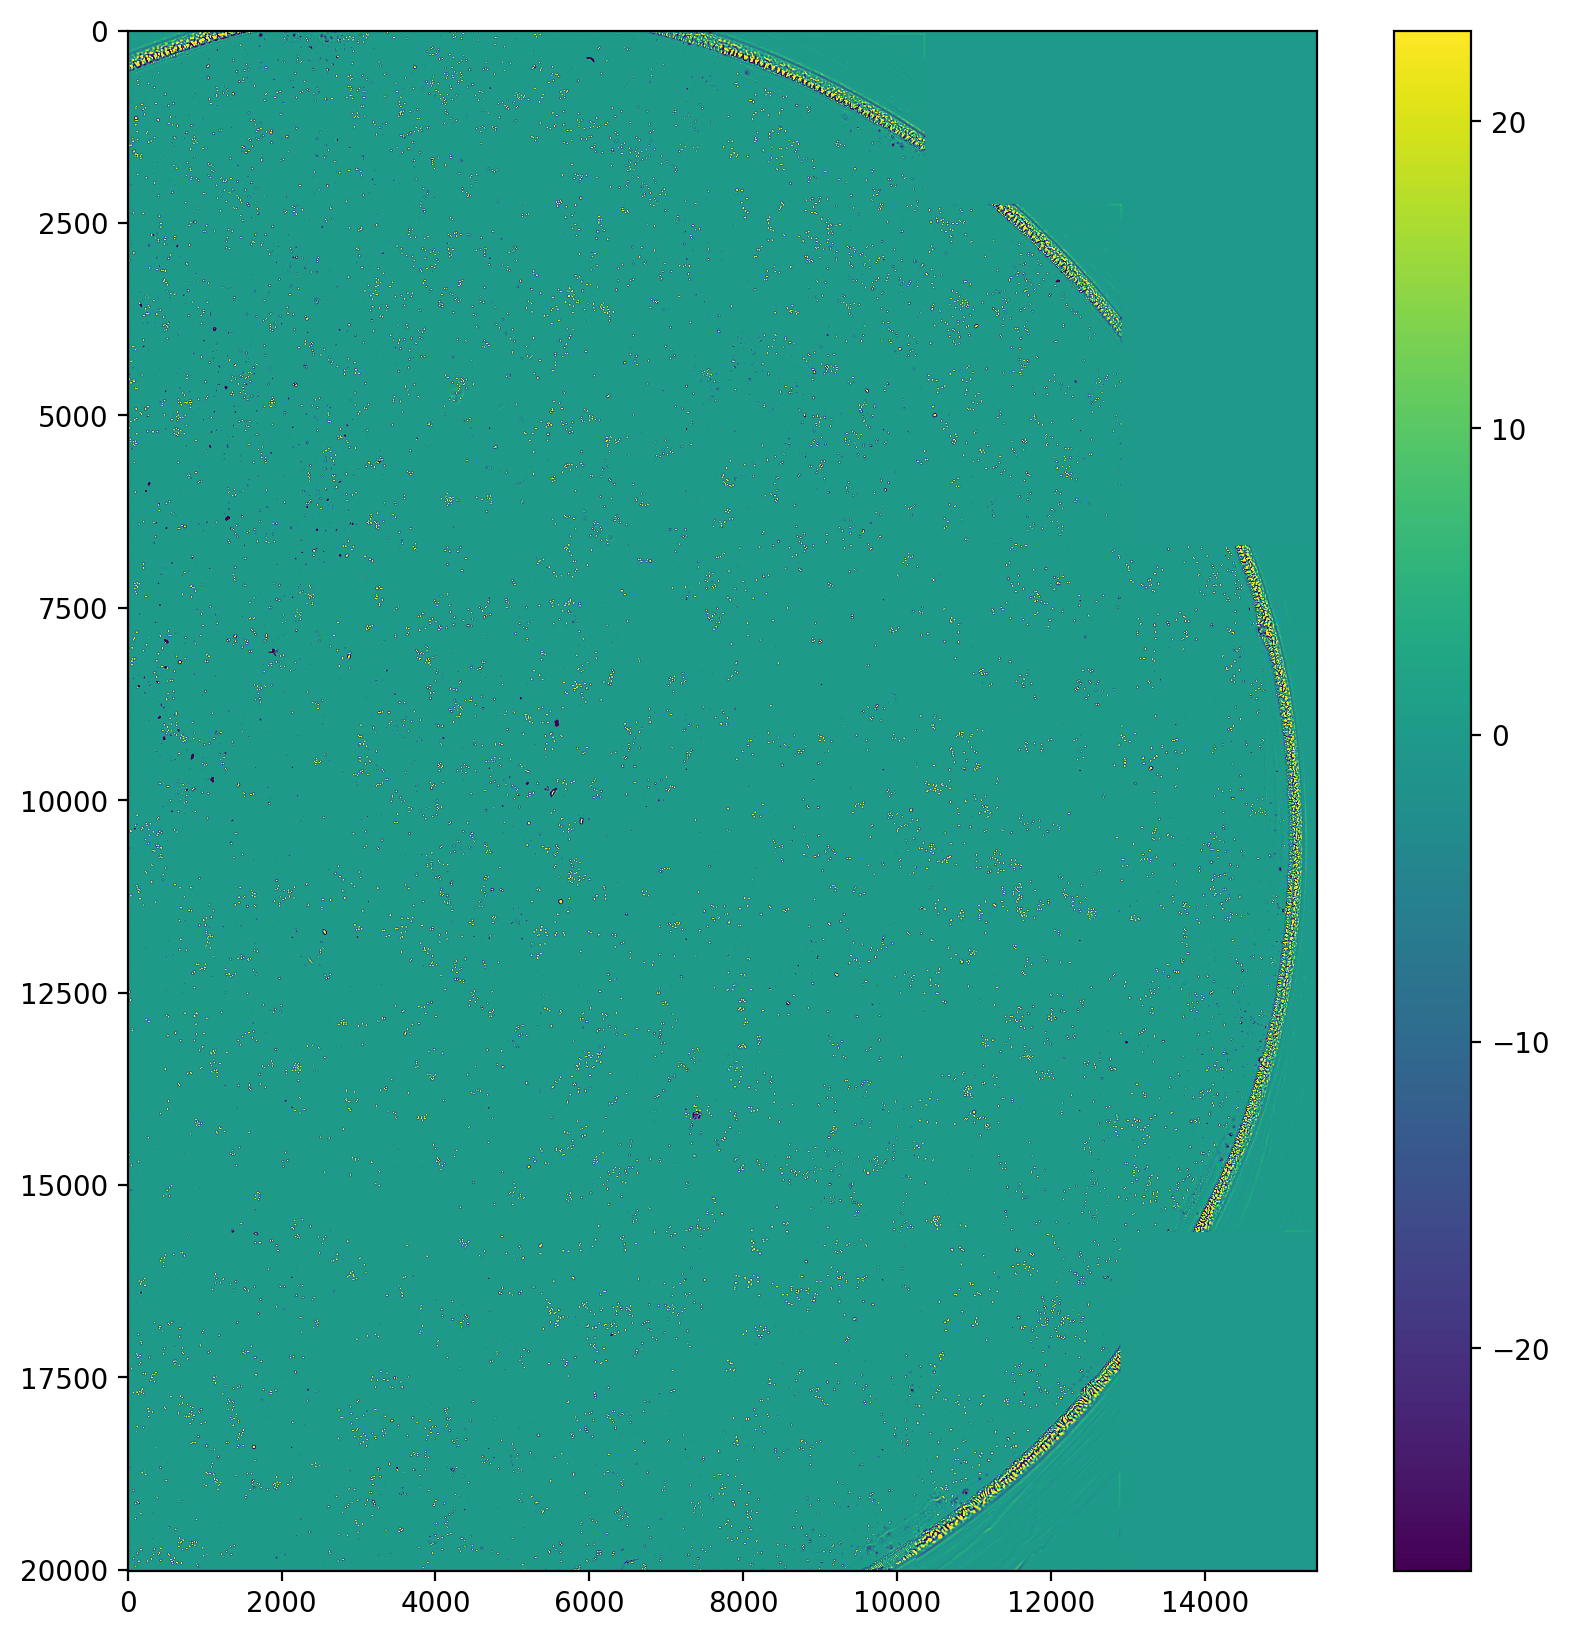

In [19]:
stitched = merge_mosaic_images(target_images[:,0], positions[["y_pos","x_pos"]].values)
plt.figure(figsize=(10,10))
#plt.imshow(stitched[:3000,:3000],vmin=qs[0],vmax=qs[1])
plt.imshow(stitched[:,:],vmin=qs[0],vmax=qs[1])
plt.colorbar()

In [20]:
all_positions = [positions]
if len(target_Ts) > 1:
    with joblib.Parallel(n_jobs=num_cpus) as parallel:
        all_positions.append(parallel(joblib.delayed(stitch_T)(_T) for _T in target_Ts[1:]))

In [21]:
all_positions_df=pd.concat(all_positions)
all_positions_df.to_csv(output_csv_path,index=False)

# Final stitch images 

In [22]:
final_positions = all_positions_df.groupby(["row","col"]).median()
final_positions = final_positions.loc[[tuple(x) for x in index_positions]]
final_positions

y_pos    x_pos
row col                  
0   0        0.0     21.0
    1       10.0   2578.0
    2       21.0   5136.0
    3       32.0   7693.0
1   4     2250.0  10247.0
    3     2241.0   7690.0
    2     2231.0   5132.0
    1     2220.0   2575.0
    0     2208.0     18.0
2   0     4416.0     15.0
    1     4428.0   2572.0
    2     4440.0   5129.0
    3     4449.0   7687.0
    4     4460.0  10244.0
3   5     6680.0  12798.0
    4     6669.0  10241.0
    3     6658.0   7685.0
    2     6650.0   5127.0
    1     6637.0   2569.0
    0     6625.0     12.0
4   0     8834.0     10.0
    1     8846.0   2567.0
    2     8860.0   5125.0
    3     8867.0   7682.0
    4     8878.0  10239.0
    5     8889.0  12796.0
5   5    11098.0  12793.0
    4    11087.0  10236.0
    3    11076.0   7679.0
    2    11069.0   5123.0
    1    11055.0   2565.0
    0    11044.0      8.0
6   0    13252.0      6.0
    1    13261.0   2561.0
    2    13277.0   5120.0
    3    13284.0   7677.0
    4    13294.0  10233.0
    5    13306.0  12790.0
7   4    15504.0  10231.0
    3    15494.0   7674.0
    2    15487.0   5117.0
    1    15476.0   2560.0
    0    15461.0      3.0
8   0    17670.0      0.0
    1    17684.0   2557.0
    2    17695.0   5114.0
    3    17702.0   7671.0
    4    17713.0  10229.0

In [23]:
mosaic_positions = final_positions[["y_pos","x_pos"]].values
final_mosaic_positions = (mosaic_positions - np.min(mosaic_positions, axis=0)[np.newaxis]).round().astype(int)
mosaic_size = (np.max(mosaic_positions, axis=0) + np.array(images.shape[-2:])).astype(int)

In [24]:
from tqdm import tqdm
from numcodecs import Zstd
synchronizer = zarr.ProcessSynchronizer(str(output_image_path).replace(".zarr",'.lock.sync'))
#with zarr.ZipStore(output_image_path, mode='w') as store:
shape = list(images.shape[1:-2])+list(mosaic_size)
chunks = [1] * len(images.shape[1:-2]) + [2048, 2048]

output_zarr = zarr.open(str(output_image_path),
                        shape=shape,
                        chunks=chunks,
                        dimension_separator="/",                        
                        compressor=Zstd(),
                        dtype=images.dtype,
                        synchronizer=synchronizer,
                        mode="w")


def process_chunk(ind):
    for M, position in enumerate(final_mosaic_positions):
        new_ind = list(ind) + [slice(position[0],position[0] + images.shape[-2]),
                               slice(position[1],position[1] + images.shape[-1])]
        im = images[tuple([M]+list(ind))]
        output_zarr[tuple(new_ind)] = im

inds = np.ndindex(images.shape[1:-2])
with joblib.Parallel(n_jobs=num_cpus) as parallel:
    parallel(joblib.delayed(process_chunk)(ind) for ind in inds)

In [25]:
stitched = zarr.open(str(output_image_path))

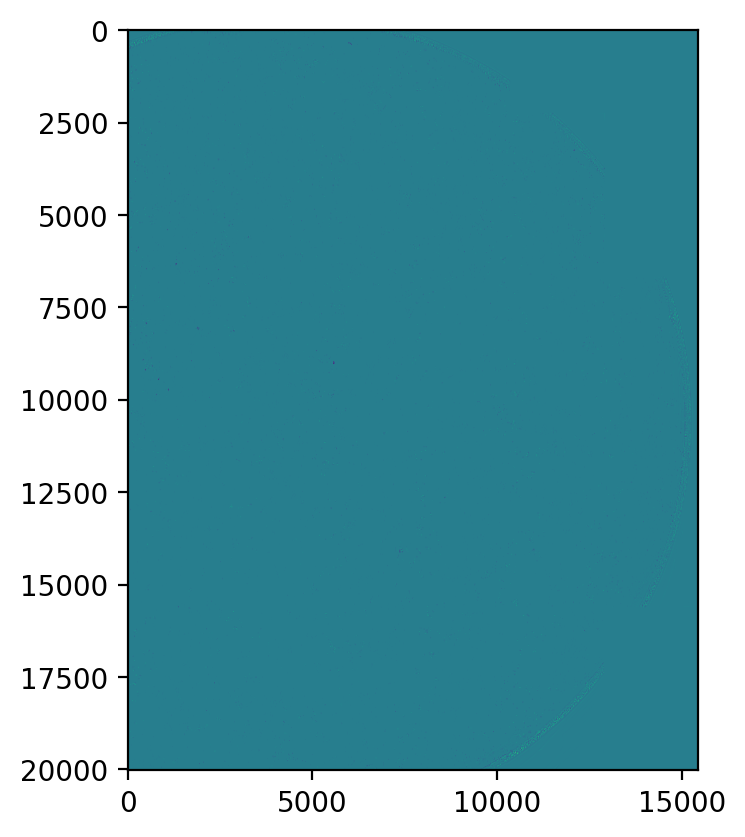

In [26]:
plt.imshow(stitched[0,0,0])

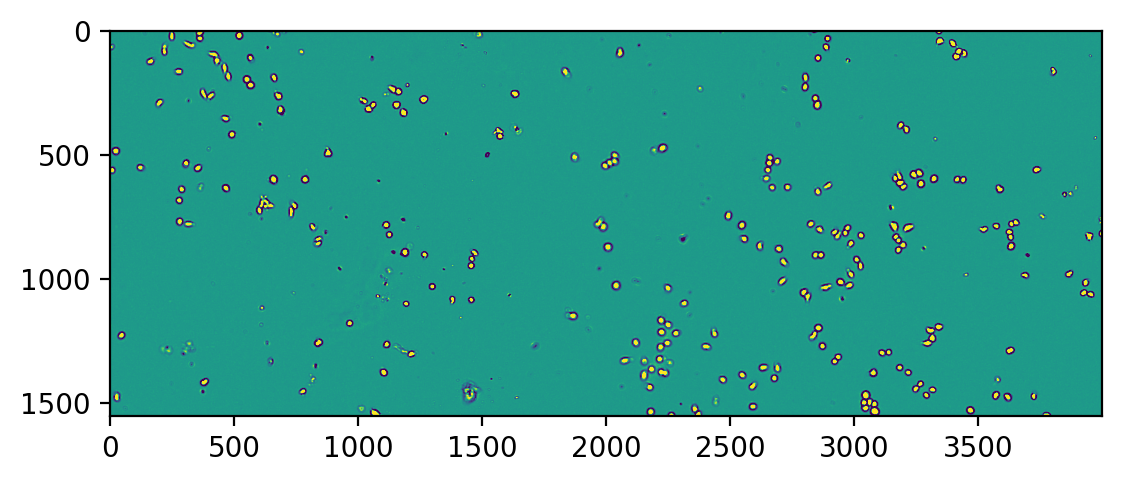

In [28]:
plt.imshow(stitched[0,1,0][2048:3600,1000:5000],vmin=qs[0],vmax=qs[1])